#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of the vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
E = 210e9

In [17]:
E*Ar

16991625880.187403

In [18]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [19]:
DT=np.diag(diag_DT) # (35) in [2]

In [20]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [21]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [22]:
CT=np.diag(diag_CT)

In [23]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [24]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [25]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [26]:
rng = np.random.default_rng()

In [27]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [28]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [29]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[-0.30154388, -0.25573256,  0.91851627],
       [-0.39283909,  0.91111266,  0.12470433],
       [-0.86876276, -0.32322527, -0.37520219]])

In [30]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.010040


In [31]:
Ret.shape

(50, 3, 3)

In [32]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [33]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [34]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000399


In [35]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [36]:
fD(dx,dy,dz,DT,Ret).T

array([[ -9716.18997359,  -2837.62065372,     93.46800338],
       [  -355.69211396,  12125.66953683,  -5267.44088825],
       [ -1570.65890558,    845.82321429,    291.49720311],
       [   977.31725302,   3501.04249744,  -6909.60152883],
       [  -124.92711147, -26262.26179139, -20541.78263921],
       [  6342.20268412,   8472.83523216,  -2910.70656022],
       [ -6938.21354001,   -874.49000485,   -295.88779282],
       [ 20350.63708258,  -8078.9969122 ,  -3018.0851798 ],
       [  7729.55587304,  42427.30717867, -31705.89894156],
       [  2991.35738638,  -3328.03489684,   2002.65927327],
       [-26167.46006084, -13245.66493616,  -5270.98706921],
       [-13935.64444517,  -9584.01956807,   8679.93434254],
       [ -2649.13289849,  -8894.16667065,    277.4330918 ],
       [  6554.52466486,  -1919.76546345,   -196.21689575],
       [  -707.64436644,   -334.353408  ,   1718.9061522 ],
       [  7407.95215637,   5975.62245133,   4737.24593169],
       [ 11157.55485239,   6867.22747496

In [37]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000364


In [38]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [39]:
I=np.identity(3)

In [40]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000550


In [41]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [42]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [43]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [44]:
DR=np.diag(diag_DR) 

In [45]:
Ar

0.08091250419136858

In [46]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [47]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [48]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [49]:
def Re_b(Ret):
    return Ret

In [50]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000197


In [51]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [52]:
phi(x,y,z,Ret,None)

array([[  81.69200474,  -12.37674741,   25.83577369],
       [  82.09977241,   -3.84374548,  -48.76089225],
       [  49.72208557, -245.59435765,  -89.51720111],
       [ -50.6846147 ,  -74.4212361 ,  -11.56239712],
       [-131.2813434 ,   -0.93099002,  142.211348  ],
       [ -67.15966832,  -55.52126788,   86.45485443],
       [-135.38503644,   74.64921631,  -99.08452341],
       [   3.73540616,  -29.25122269,  -72.01804459],
       [ -10.04250469,  -25.1142496 ,  -19.66890365],
       [  60.11505804,  -20.4607137 ,   87.43213357],
       [  12.27833567,   -4.1033302 ,  -80.22540424],
       [ 138.69403117,  -50.10669282, -194.71733779],
       [  -2.64461972,  -94.42639684,   93.63795293],
       [  43.53962007,  137.97491273,   12.4358785 ],
       [  83.59972906,   57.83376008,   66.26726968],
       [  50.83222195,   20.35007727,  -62.44859515],
       [-195.00622108,  109.96980391,   29.31282533],
       [-102.77702512,  -99.3197198 ,   13.05225484],
       [  25.83821519,   49.

In [53]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000247


In [54]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [55]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [56]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002300


In [57]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [58]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.003185


In [59]:
ωe(φ,θ,ψ,None,None)

array([[-0.73995735,  2.19912725, -0.0308244 ],
       [-1.73672473, -1.07303906,  0.34848214],
       [ 0.39142292,  0.34482296, -0.19804597],
       [-0.7707848 , -0.08427306, -1.85577718],
       [ 1.16034278,  0.26276149, -1.41039048],
       [ 0.56598623,  0.18284743, -1.01222952],
       [-0.87119125, -1.34740995, -0.94003063],
       [-0.19960009,  0.14975631, -0.05146278],
       [ 0.88791634,  0.41907321, -0.67745458],
       [-0.44486105, -0.69938216, -0.15666454],
       [ 0.15972794, -1.39969932,  0.94662308],
       [ 0.44167387,  0.9789658 , -0.31010694],
       [-1.74372089,  0.2908347 ,  0.09789673],
       [ 1.05104712,  0.12854613,  0.06920371],
       [-0.50123806, -0.30465553, -0.11767889],
       [ 1.19606906, -0.43564386, -0.48699134],
       [-1.20955474,  0.0437396 , -0.28365849],
       [-0.54625661, -2.1678657 ,  0.61140975],
       [-0.31851244, -0.94224971, -0.71720877],
       [-0.60391929,  0.71173826, -0.90761284],
       [ 0.38204454, -1.4439506 ,  1.111

In [60]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [61]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[  56.43464761,   53.66181701,  -79.50655977, -137.13482956,
          36.05460706,  -40.39221734,  203.68002508,  -12.29050583,
         -25.25647433,  -64.35394447,  116.17574914, -206.16004058,
          36.47720217,   -7.9497923 ,  -13.38287858,   37.11565868,
          32.47599986,   32.42950798,  127.53080693,  -50.27572009,
          54.88738039, -279.79699735,  180.37660131, -193.56814652,
         -98.55308651,    4.00383926,  131.08907245,  -18.70888179,
          -3.69412226,  145.37461166,  -91.41335997,  -46.63875657,
          32.42846793,  162.86355113,    1.46153546,  207.06547018,
          -6.52574214,  -34.14171117, -306.26109586,  -44.8923812 ,
          39.46704461,    7.56895737,  -25.22286999,    5.95916046,
         -32.44969734,   17.19390996,  165.75843612,   23.26064262,
        -288.06276751,   47.50068524],
       [  16.59926382,  -56.07394186,   25.19182709,   85.14723408,
          20.14404113,   19.04873969,   40.94451282,  -14.56704263,
         

In [62]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [63]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 3.82121375e-04, -4.49166952e-04,  1.56075591e-03,
         6.28582069e-04,  1.43140904e-03,  1.41974700e-03,
        -1.73732000e-03, -4.27663922e-04,  5.44529224e-05,
         1.07891769e-03, -7.61213096e-04, -1.44609188e-03,
         1.88062469e-03, -1.25537777e-03,  8.43342910e-05,
        -8.27978435e-04, -8.06561681e-04,  1.12370846e-03,
        -1.47082636e-03, -2.61593332e-04,  8.62712241e-04,
         2.00243274e-03,  2.31423995e-03, -1.30575694e-03,
         2.40673502e-03, -3.96554862e-04, -2.99003654e-05,
        -4.61317416e-04,  1.67771733e-03, -7.92840810e-04,
         2.63451582e-03, -2.27309618e-04,  4.06102434e-04,
         1.84172287e-03,  3.73023032e-04, -2.78830060e-04,
        -1.85668951e-03,  2.96218496e-04,  3.18433804e-03,
        -8.33109132e-05, -1.52734347e-03, -3.85581586e-04,
         6.40537382e-04,  3.41182280e-04,  1.10026821e-04,
         9.31389626e-04,  2.43089451e-04,  9.75438524e-04,
         3.27339675e-03,  2.02261699e-04],
       [ 5.58

In [64]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004643


In [65]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [66]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [67]:
d_s(ne,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-2.03863908e+02,  1.24048906e+02,  2.82477245e+02,
        -4.68263371e+02,  1.36233423e+02,  1.18665537e+02,
         3.83688415e+01,  2.75241644e+01,  9.55103252e+01,
         1.10550097e+02, -2.60520653e+02,  4.48199431e+02,
         3.33664790e+00,  7.87785620e+01, -1.49540650e+01,
         5.32358413e+01,  3.96730912e+01, -2.37933669e+02,
        -3.25307098e+02, -6.99519299e-01, -1.06929541e+02,
         4.98418595e+01,  1.22530037e+02, -2.05112474e+02,
        -5.45187613e+02,  3.83655973e+01,  2.34645505e+02,
         7.08895289e-01, -2.67062988e+02, -4.72665806e+01,
        -5.89950193e+02,  8.82874475e+01,  2.36329959e+02,
        -4.24139295e+01, -1.20457771e+02,  5.87915991e+01,
         1.92134847e+01, -9.74029929e+00, -3.64268257e+02,
        -3.97788291e+01, -3.51874528e+02, -2.43812020e+02,
         2.47093552e+00,  6.32576710e+02,  8.61610736e+01,
        -1.37865686e+02,  2.40969022e+02,  1.98486837e+02,
         1.13770992e+02,  1.53158448e+02],
       [-9.48

In [68]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.01459238e-04, -1.18115030e-04,  1.82527039e-04,
        -7.97678745e-05, -5.78070538e-05, -9.18615336e-05,
        -1.84786680e-04,  9.80127353e-05,  1.01629167e-05,
        -9.61470594e-07,  9.52136277e-05,  2.73751023e-04,
         2.41255652e-05,  6.14798883e-07,  1.47319150e-04,
         1.02809853e-04,  3.05249480e-06,  1.28428765e-04,
        -1.06306315e-04, -1.32446923e-04,  5.67581962e-05,
        -9.13519973e-05, -5.89063836e-05, -5.72478064e-05,
        -6.31402107e-05,  5.81004247e-05, -9.22019034e-05,
        -1.11747410e-05,  2.05051140e-05, -1.79670962e-04,
         7.32656431e-05,  1.75539733e-04,  5.00418400e-05,
         1.73579231e-04,  1.04051654e-04, -8.31254774e-05,
        -3.49958750e-04,  5.98765753e-05,  1.70491864e-04,
         1.43751973e-05,  5.57746695e-05, -2.09260769e-05,
        -2.46425191e-05,  1.65550571e-05, -1.80710178e-04,
         8.25446083e-05,  3.64242494e-05,  4.29173917e-05,
         2.58268082e-04, -1.67540712e-04],
       [ 4.56

In [69]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [70]:
ne_(dx,dy,dz,DT,Ret)

array([[ 9.71618997e+03,  3.55692114e+02,  1.57065891e+03,
        -9.77317253e+02,  1.24927111e+02, -6.34220268e+03,
         6.93821354e+03, -2.03506371e+04, -7.72955587e+03,
        -2.99135739e+03,  2.61674601e+04,  1.39356444e+04,
         2.64913290e+03, -6.55452466e+03,  7.07644366e+02,
        -7.40795216e+03, -1.11575549e+04, -2.45026683e+04,
         4.22378782e+02, -5.22351323e+03, -1.21251949e+04,
        -3.46543575e+03,  2.70941858e+03, -7.79994868e+03,
        -1.76599781e+03,  2.56787507e+02, -1.83281930e+04,
         2.62936211e+04, -3.10011643e+04, -8.52920257e+03,
        -1.43540370e+03, -2.63659537e+03,  7.85575270e+02,
        -1.41627294e+03,  2.20420902e+03, -5.78624611e+03,
         4.45043413e+03, -3.97704731e+03, -1.63686056e+02,
         5.74390672e+04,  1.22876803e+04, -7.55618395e+03,
        -3.05268144e+03,  2.70783028e+03,  1.96667476e+04,
         4.03801797e+03, -2.76744258e+03,  1.28345969e+03,
         1.76368906e+03,  2.46552374e+04],
       [ 2.83

In [71]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006051


In [72]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 2.74224723e+07,  3.26152404e+08,  1.22288306e+08],
       [ 1.73619979e+05, -1.01282962e+08,  2.27660697e+07],
       [-8.53490763e+08, -5.13674975e+07,  2.31110038e+08],
       [ 7.92375003e+07,  2.05494478e+08, -2.62769356e+08],
       [-2.01338596e+08, -1.55827667e+08, -1.95941036e+07],
       [-5.30928318e+07,  7.93562621e+07,  1.98021927e+08],
       [-2.07546821e+08, -8.37206879e+07, -4.53518088e+07],
       [-9.49106013e+08,  1.09034128e+08,  1.36558325e+08],
       [-4.01764329e+06, -1.09981012e+08, -1.44705874e+07],
       [-3.19820269e+08, -3.31645372e+08, -2.21095162e+08],
       [-3.78996897e+06,  2.56107312e+08, -4.41360198e+06],
       [-7.66791433e+07, -3.49615608e+08,  9.85842647e+07],
       [-9.23031482e+08,  2.65211475e+06,  5.98876612e+06],
       [-2.60217194e+08,  1.51523193e+07,  9.39309618e+07],
       [-8.37798185e+08, -1.58454362e+08, -1.73408455e+08],
       [-3.43320937e+06,  1.56852534e+06,  5.48044197e+07],
       [-6.53211379e+08, -1.35032412e+07

In [73]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000423


In [74]:
Re_b(Ret).shape

(50, 3, 3)

In [75]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans


In [76]:
Irho_e(Ret).shape

(50, 3, 3)

In [77]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000176


In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.004447


In [82]:
d_me_

array([[ 9.09331162e-15,  3.84868001e-09, -6.52691164e-10],
       [ 3.11401469e-16,  4.97381625e-10, -3.25315815e-10],
       [ 8.99914461e-14,  3.87872489e-09, -3.45542271e-09],
       [ 1.84472869e-14,  1.11779050e-09, -4.08330557e-09],
       [ 3.43592051e-14,  1.56863187e-09, -1.36277465e-10],
       [ 1.41303968e-14,  4.10312343e-10, -3.93597077e-09],
       [ 3.50493637e-14,  1.73063559e-09, -2.71700301e-10],
       [ 9.65794945e-14,  4.41746473e-09, -4.35204248e-09],
       [ 2.52742647e-15,  5.64823851e-10, -1.67860395e-10],
       [ 4.67739480e-14,  3.13429310e-09, -1.89784386e-09],
       [ 2.43017073e-15,  1.44926855e-09, -3.70756265e-11],
       [ 1.80457102e-14,  2.50800122e-09, -7.21626683e-10],
       [ 9.48173843e-14,  1.09787146e-10, -1.40113568e-10],
       [ 4.07556753e-14,  1.03779061e-10, -1.18811894e-09],
       [ 8.88757438e-14,  3.43064375e-09, -3.14296606e-09],
       [ 2.27507482e-15,  7.45709253e-12, -1.56194146e-09],
       [ 7.52829474e-14,  1.50048241e-10

In [83]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [84]:
ne_(dx,dy,dz,DT,Ret)

array([[ 9.71618997e+03,  3.55692114e+02,  1.57065891e+03,
        -9.77317253e+02,  1.24927111e+02, -6.34220268e+03,
         6.93821354e+03, -2.03506371e+04, -7.72955587e+03,
        -2.99135739e+03,  2.61674601e+04,  1.39356444e+04,
         2.64913290e+03, -6.55452466e+03,  7.07644366e+02,
        -7.40795216e+03, -1.11575549e+04, -2.45026683e+04,
         4.22378782e+02, -5.22351323e+03, -1.21251949e+04,
        -3.46543575e+03,  2.70941858e+03, -7.79994868e+03,
        -1.76599781e+03,  2.56787507e+02, -1.83281930e+04,
         2.62936211e+04, -3.10011643e+04, -8.52920257e+03,
        -1.43540370e+03, -2.63659537e+03,  7.85575270e+02,
        -1.41627294e+03,  2.20420902e+03, -5.78624611e+03,
         4.45043413e+03, -3.97704731e+03, -1.63686056e+02,
         5.74390672e+04,  1.22876803e+04, -7.55618395e+03,
        -3.05268144e+03,  2.70783028e+03,  1.96667476e+04,
         4.03801797e+03, -2.76744258e+03,  1.28345969e+03,
         1.76368906e+03,  2.46552374e+04],
       [ 2.83

### Static solution

In [85]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [86]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [87]:
Fx_0=82945396

In [88]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [89]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [90]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [91]:
delta_x=horizontal_length/(node_N-1)

In [92]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [93]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [94]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

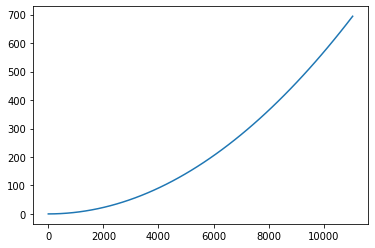

In [95]:
plt.plot(x0, z0)
plt.show()

In [96]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [97]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [98]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [99]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [101]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [103]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [104]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [105]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [106]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

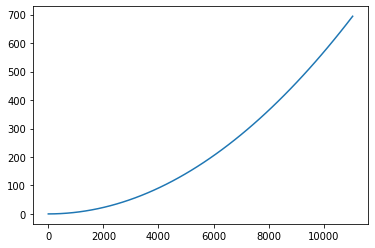

In [107]:
plt.plot(x0_, z0_)
plt.show()

In [108]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [109]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [110]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [111]:
vehicle=semisub('DPcontrol',2,2,40.0,0,0) 

In [112]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [113]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

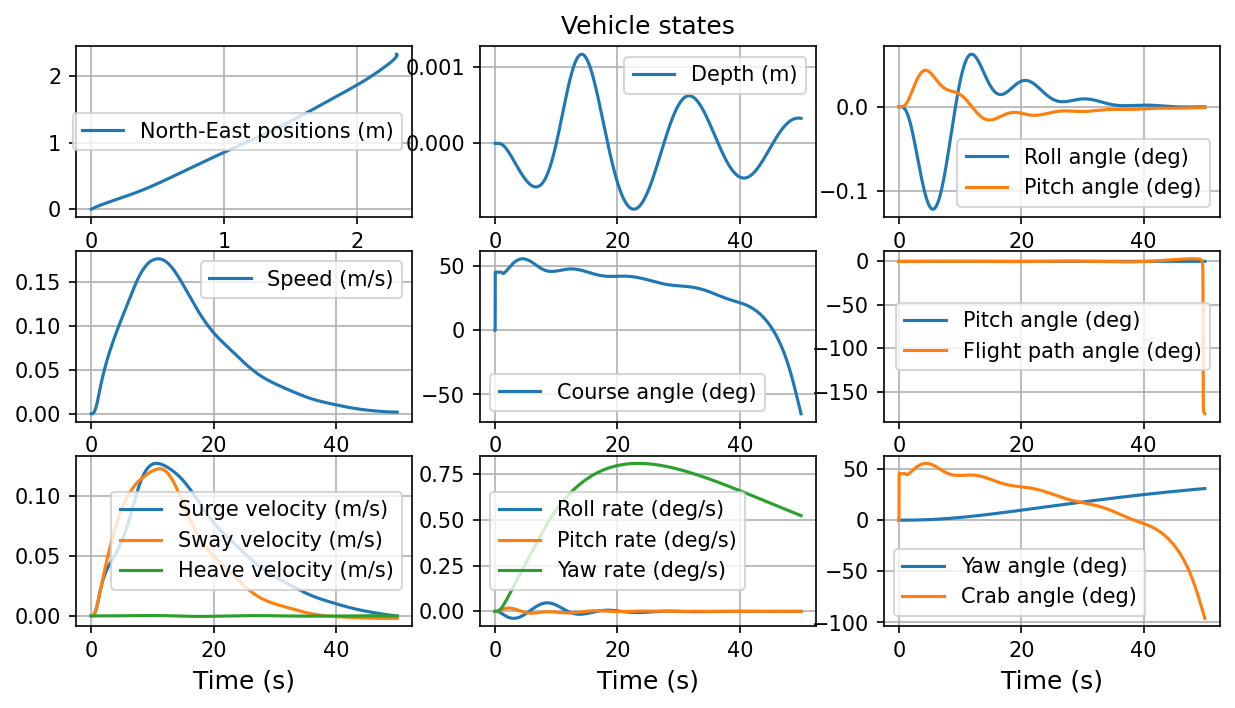

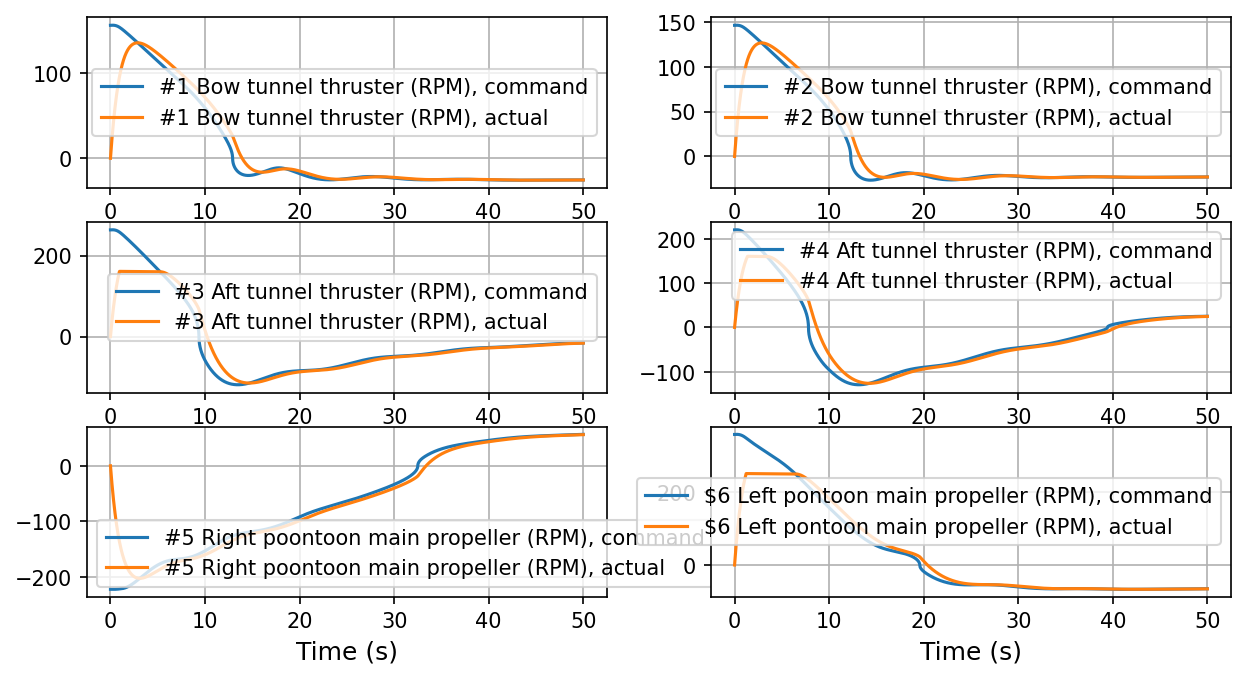

In [114]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [115]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

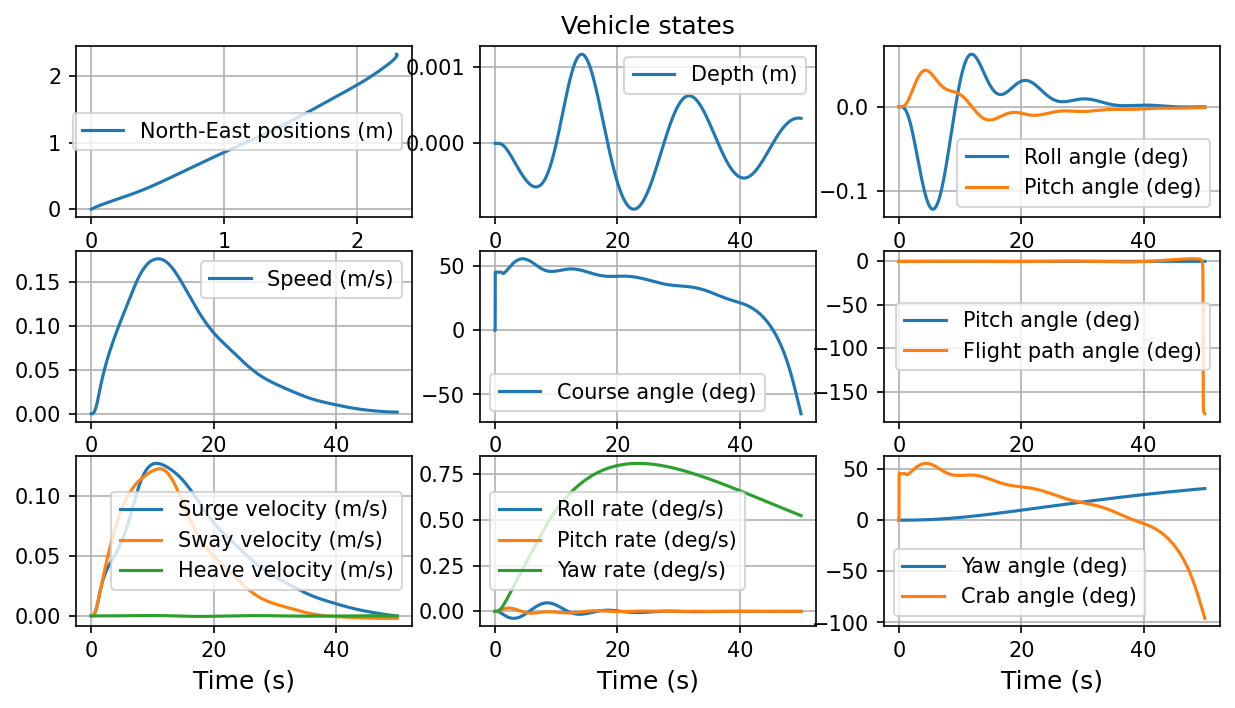

In [116]:
plotVehicleStates(simTime, simData, 3)

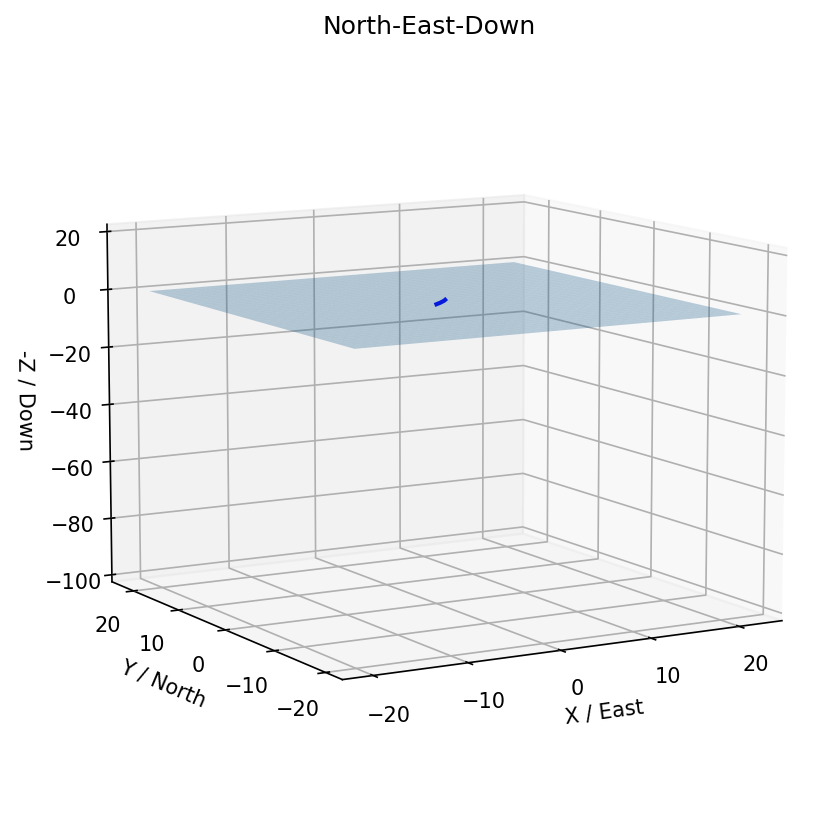

In [117]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [118]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [119]:
def grayscott1d(t, Q):
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
    force_schedule = t/15 if t<15 else 1
    tau_force = force_schedule*1.400326*n_ # [N]


    Z0=np.dot(Re_b(Ret),tau_force[:3])   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 +Z0)

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),
                                   Z).T 
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [120]:
tspan = (0., 40)

In [ ]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

### Results

In [ ]:
fin=us

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

In [ ]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()